In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# data_path = './../../Data/diabetes/'
# X = pd.read_csv(data_path + 'diabetes.csv', usecols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
#        'BMI', 'DiabetesPedigreeFunction', 'Age']).to_numpy()

# y = pd.read_csv(data_path + 'diabetes.csv', usecols = ['Outcome']).to_numpy()

# X = X - np.min(X, axis = 0)
# X = X / np.max(X, axis = 0)


# np.savetxt(data_path + "X.tsv", X, delimiter="\t")
# np.savetxt(data_path + "y.tsv", y, delimiter="\t")



In [2]:
base_path = base_path = '/home/jim/Documents/AI/fact/reproduction/'
sys.path.insert(0, base_path)
config_path = f'{base_path}configs/vae.json'
import json
from types import SimpleNamespace
config = SimpleNamespace(**json.load(open(config_path, 'r')))

In [3]:
config

namespace(features_path='./Reproduction/Housing/Data/X.tsv',
          labels_path='./Reproduction/Housing/Data/y.tsv',
          model_dir='./Models/',
          batch_size=128,
          min_epochs=200,
          stopping_epochs=25,
          tol=0.001,
          eval_freq=1,
          lr=0.001)

In [5]:
data_path = f'{base_path}Data/diabetes/diabetes.csv'
config.features_path = data_path + "X.tsv"
config.labels_path = data_path + "y.tsv"
config.model_dir = f'{base_path}Models'
config.dataset = "diabetes"

In [6]:
from Model import *

In [7]:
model = Model.Initialize('vae', None, pretrained_path=f'{base_path}Models/scvis_diabetes.pt')

Loading the pretrained model...


In [8]:
# import pandas as pd
x = pd.read_csv(f'{base_path}Data/diabetes/X.tsv', sep="\t").to_numpy()
y = pd.read_csv(f'{base_path}Data/diabetes/y.tsv', sep="\t").to_numpy().tolist()

In [9]:
data_rep = model.Encode(x)

In [13]:
colors = []
for label in y:
    if label[0] == 1.0:
        colors.append('red')
    else:
        colors.append('blue')

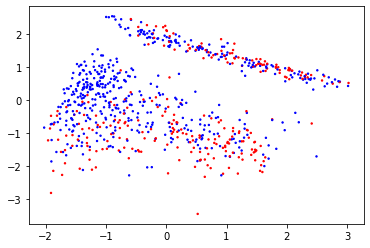

In [14]:
import matplotlib.pyplot as plt
plt.scatter(data_rep[:,0], data_rep[:,1], c=colors, s=2)

In [15]:
from sklearn.cluster import KMeans
num_clusters = 3

kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(data_rep)

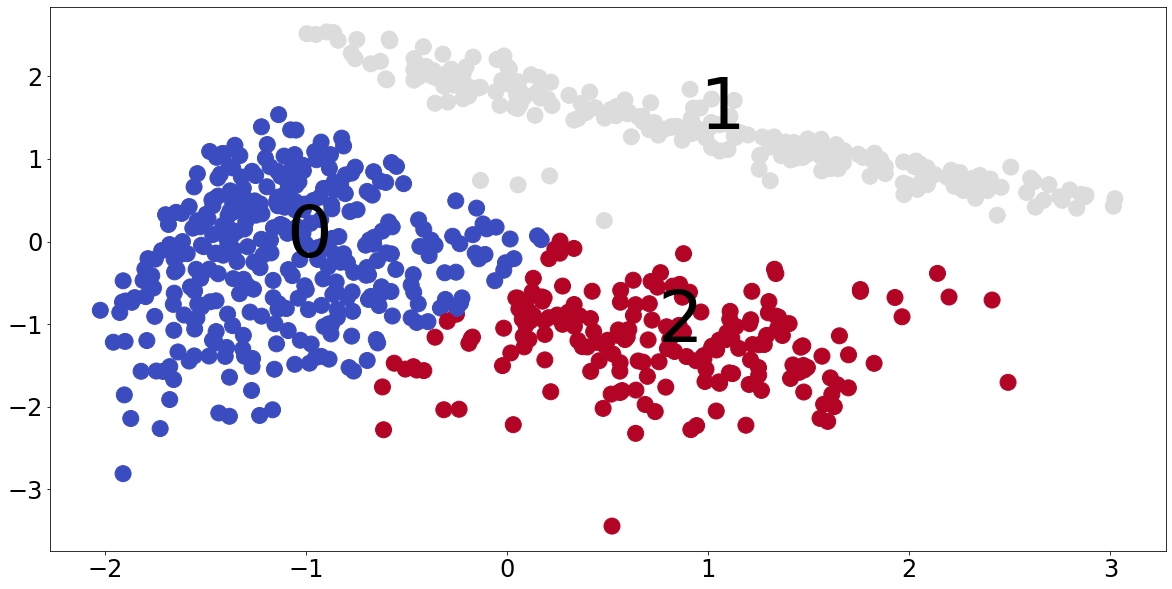

In [16]:
from eldr.plotter.myplot import *
means, centers, indices = plot_groups(x, data_rep.numpy(), num_clusters, kmeans.labels_, name = "./synth-rep.png")

In [17]:
from eldr.explain.explain_cs import *
epsilon = 0

Explainer = Explain(model, means, centers, use_scaling=True)

epsilons = np.linspace(0, 2.0, num=100).tolist()
for iter_epsilon in epsilons:
    mean_, min_, max_ = Explainer.eval_epsilon(torch.tensor(x), indices, iter_epsilon)
    if mean_ >= 0.95 and min_ >= 0.95 and max_>= 0.95:
        epsilon = iter_epsilon
        break
print(epsilon)

0.24242424242424243


/home/jim/Documents/AI/fact/reproduction/eldr/plotter/myplot.py:106: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home/jim/anaconda3/envs/factai/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


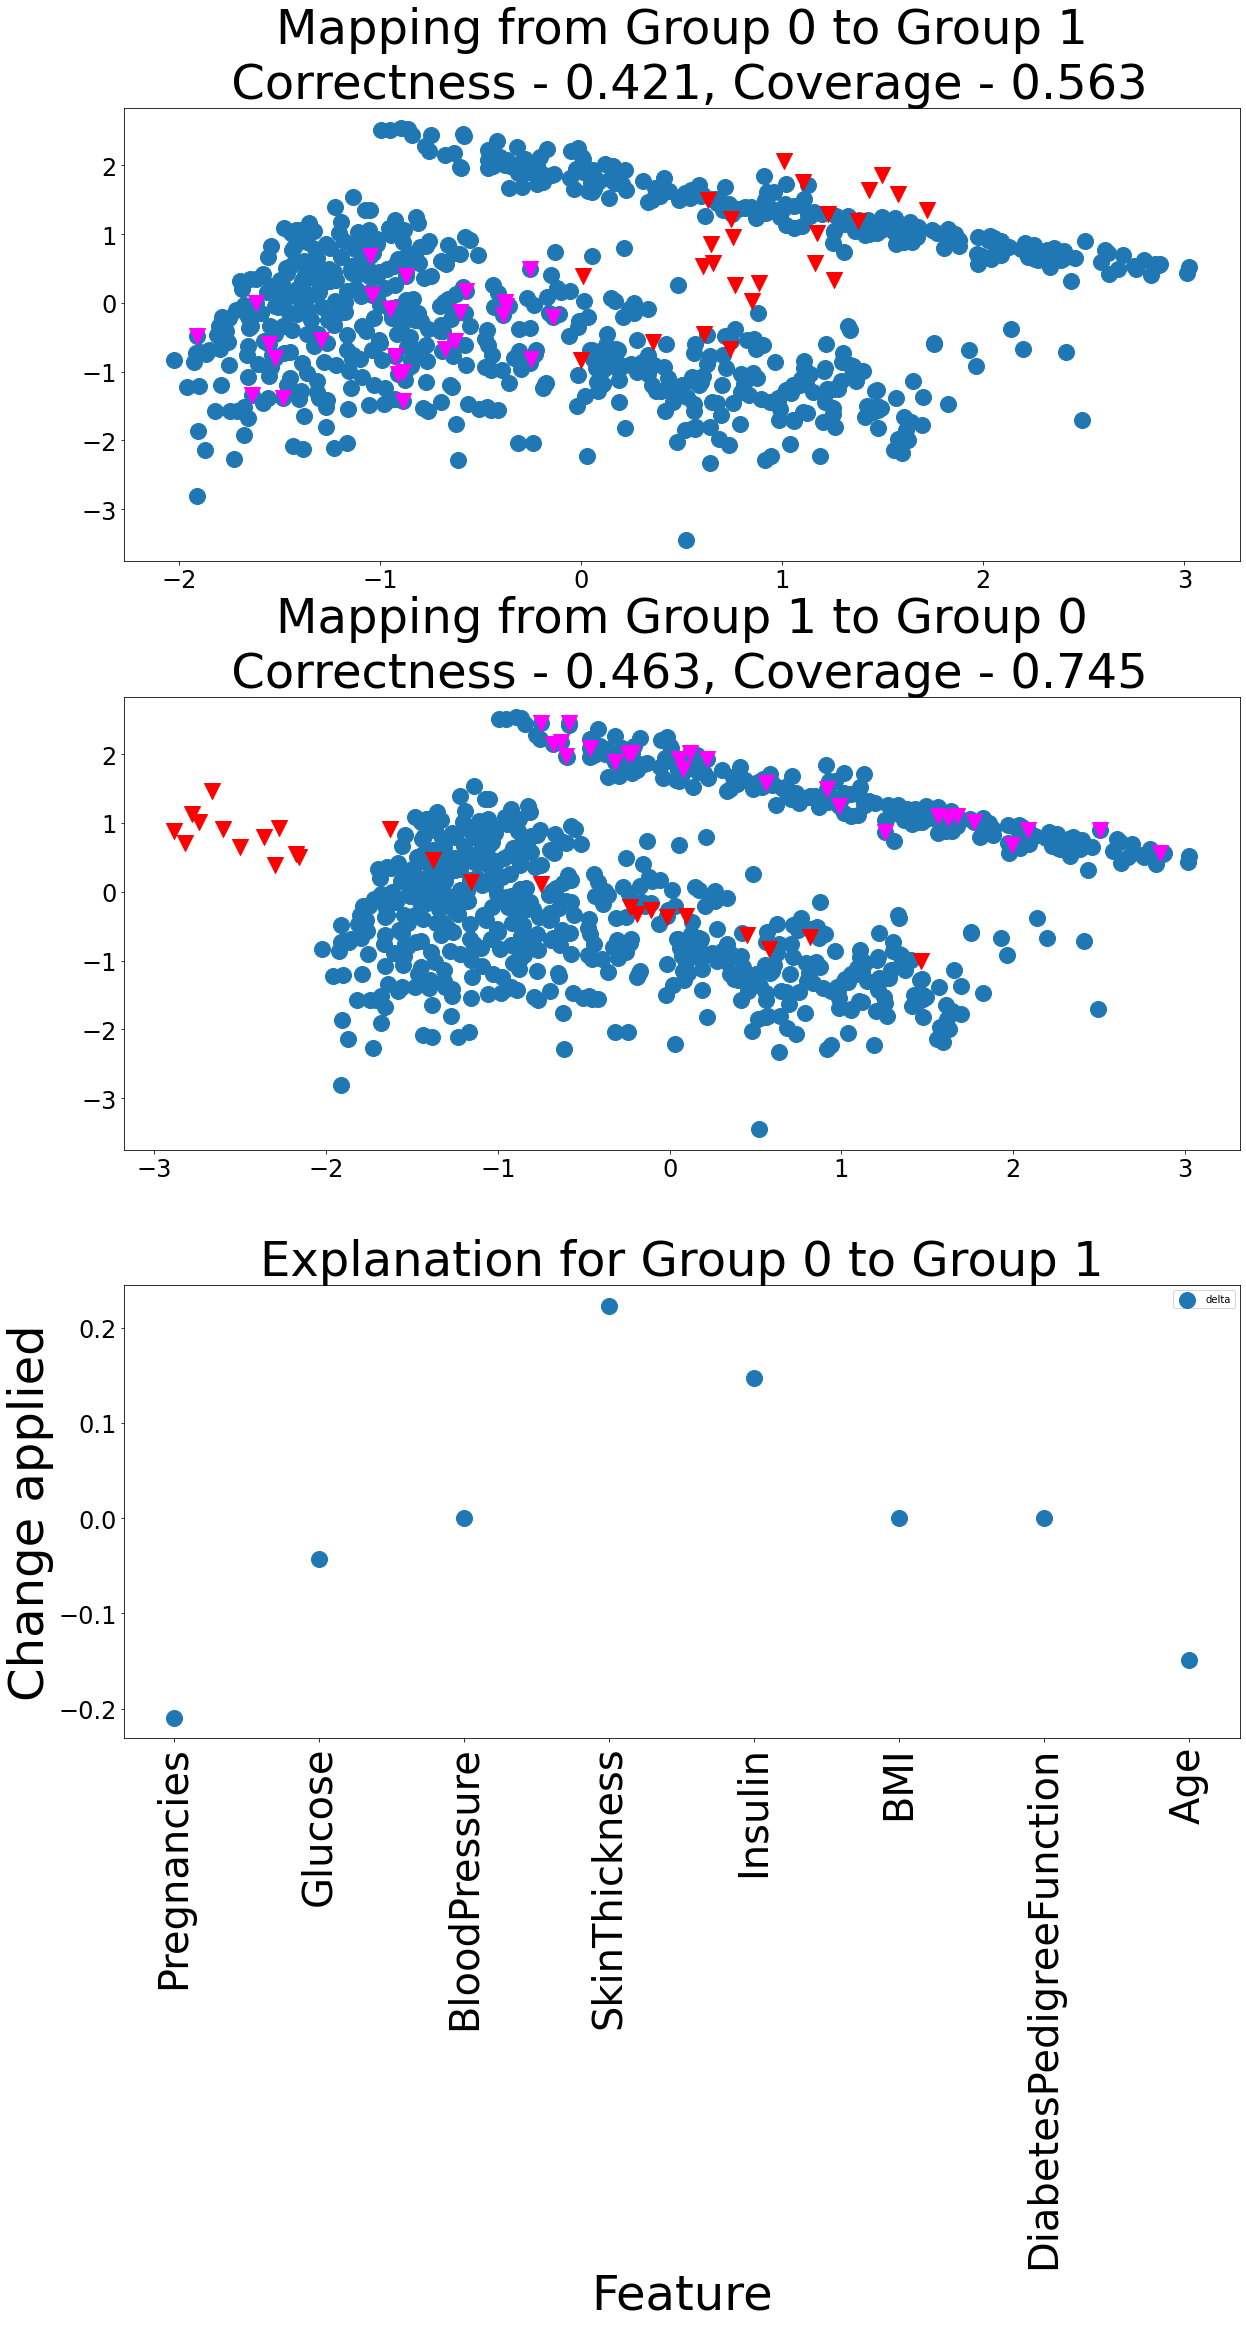

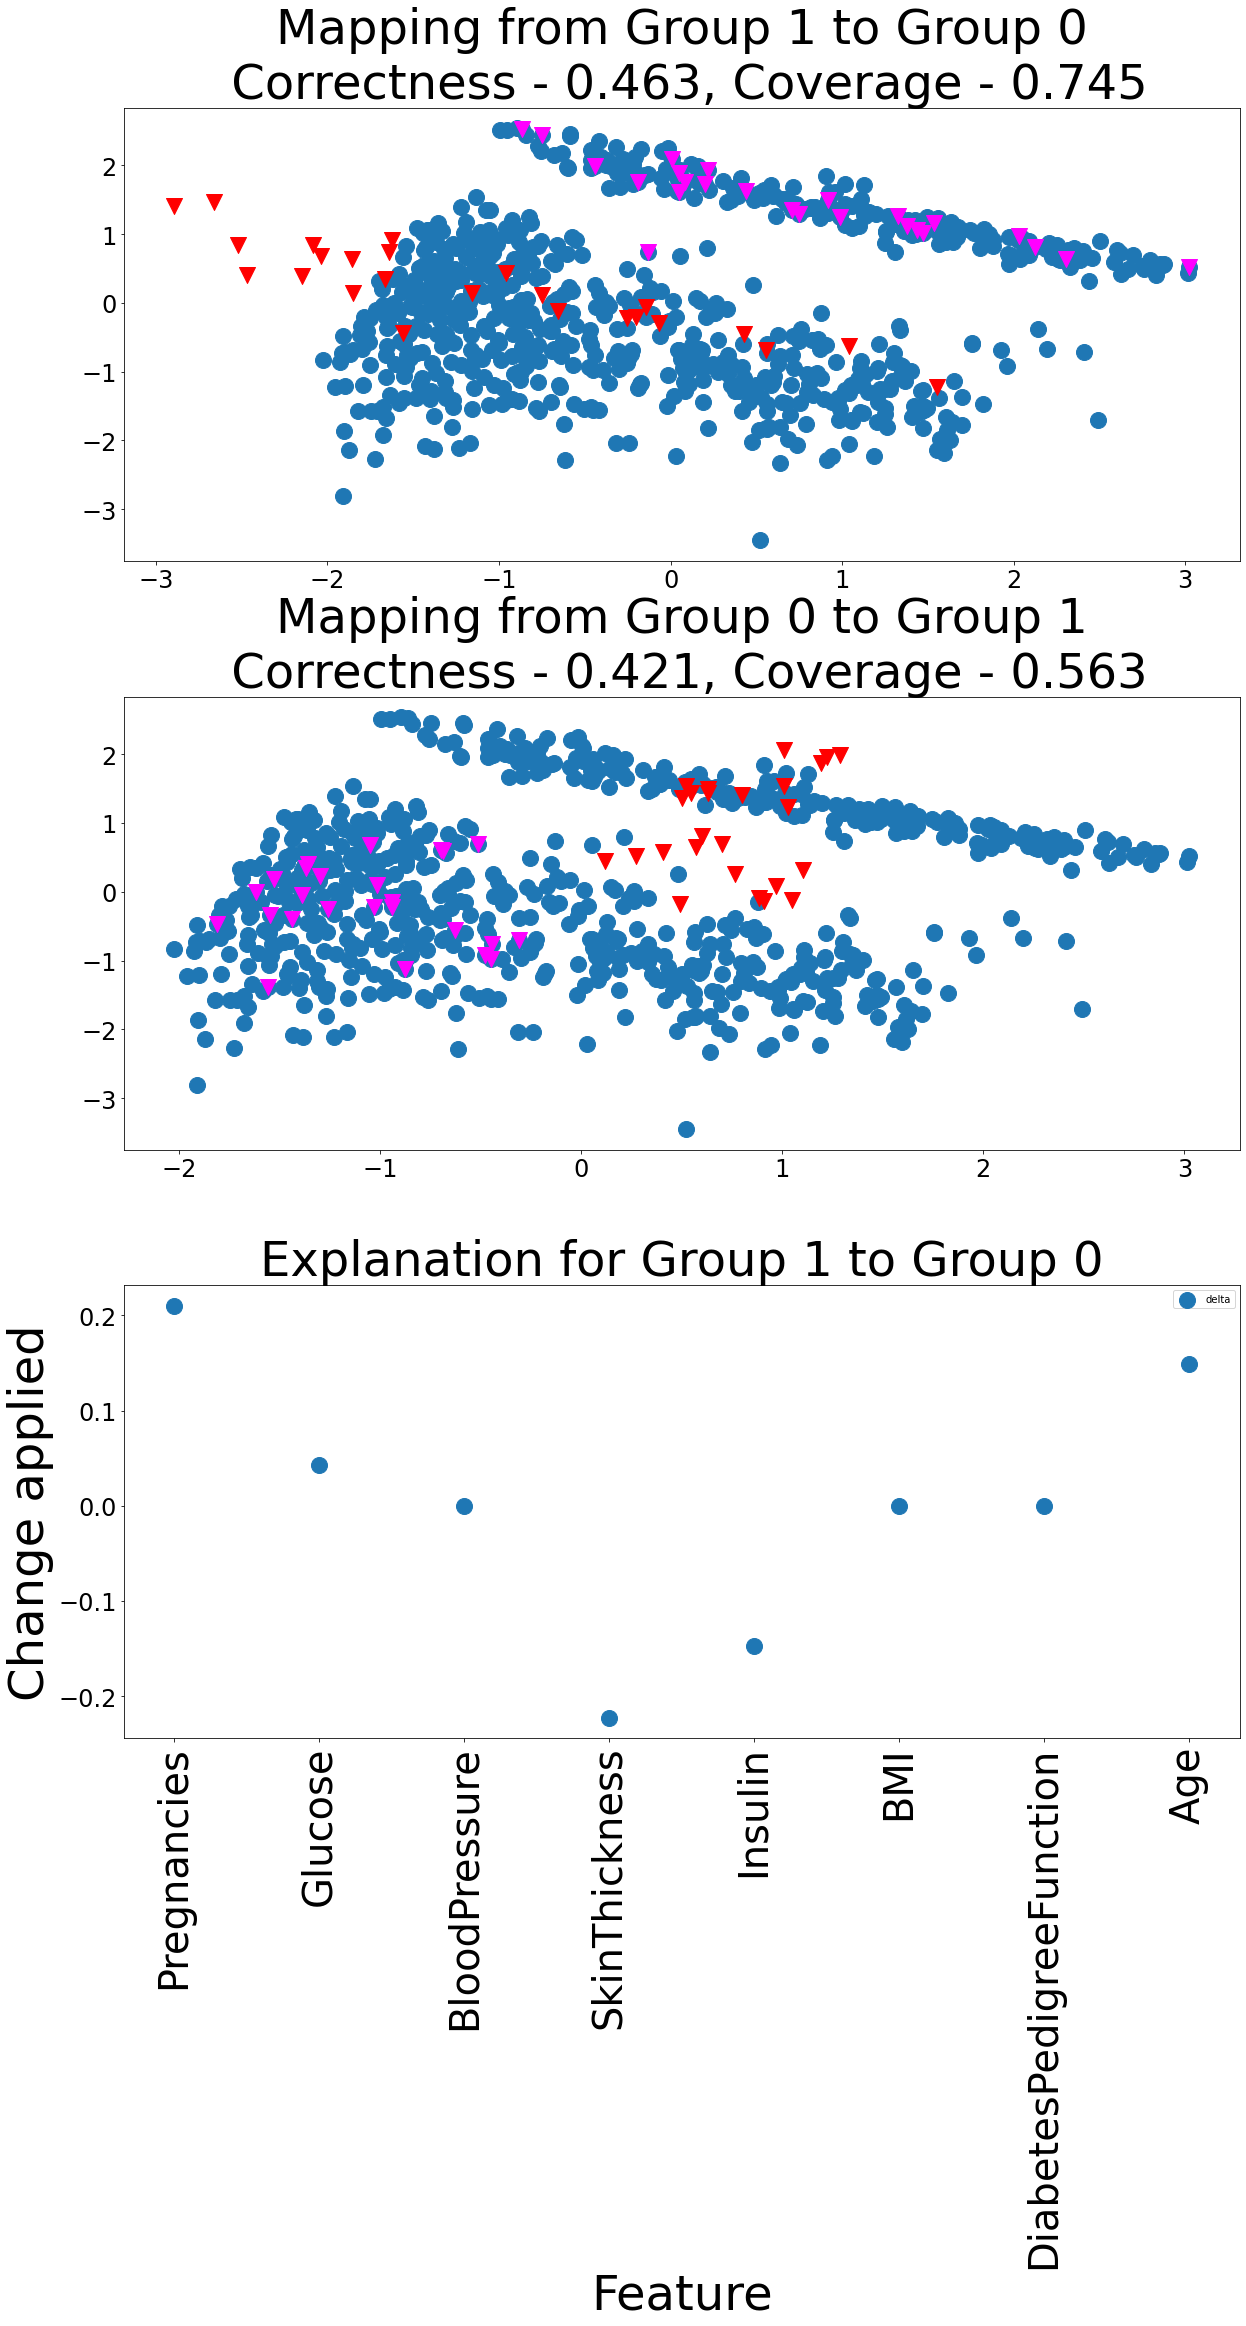

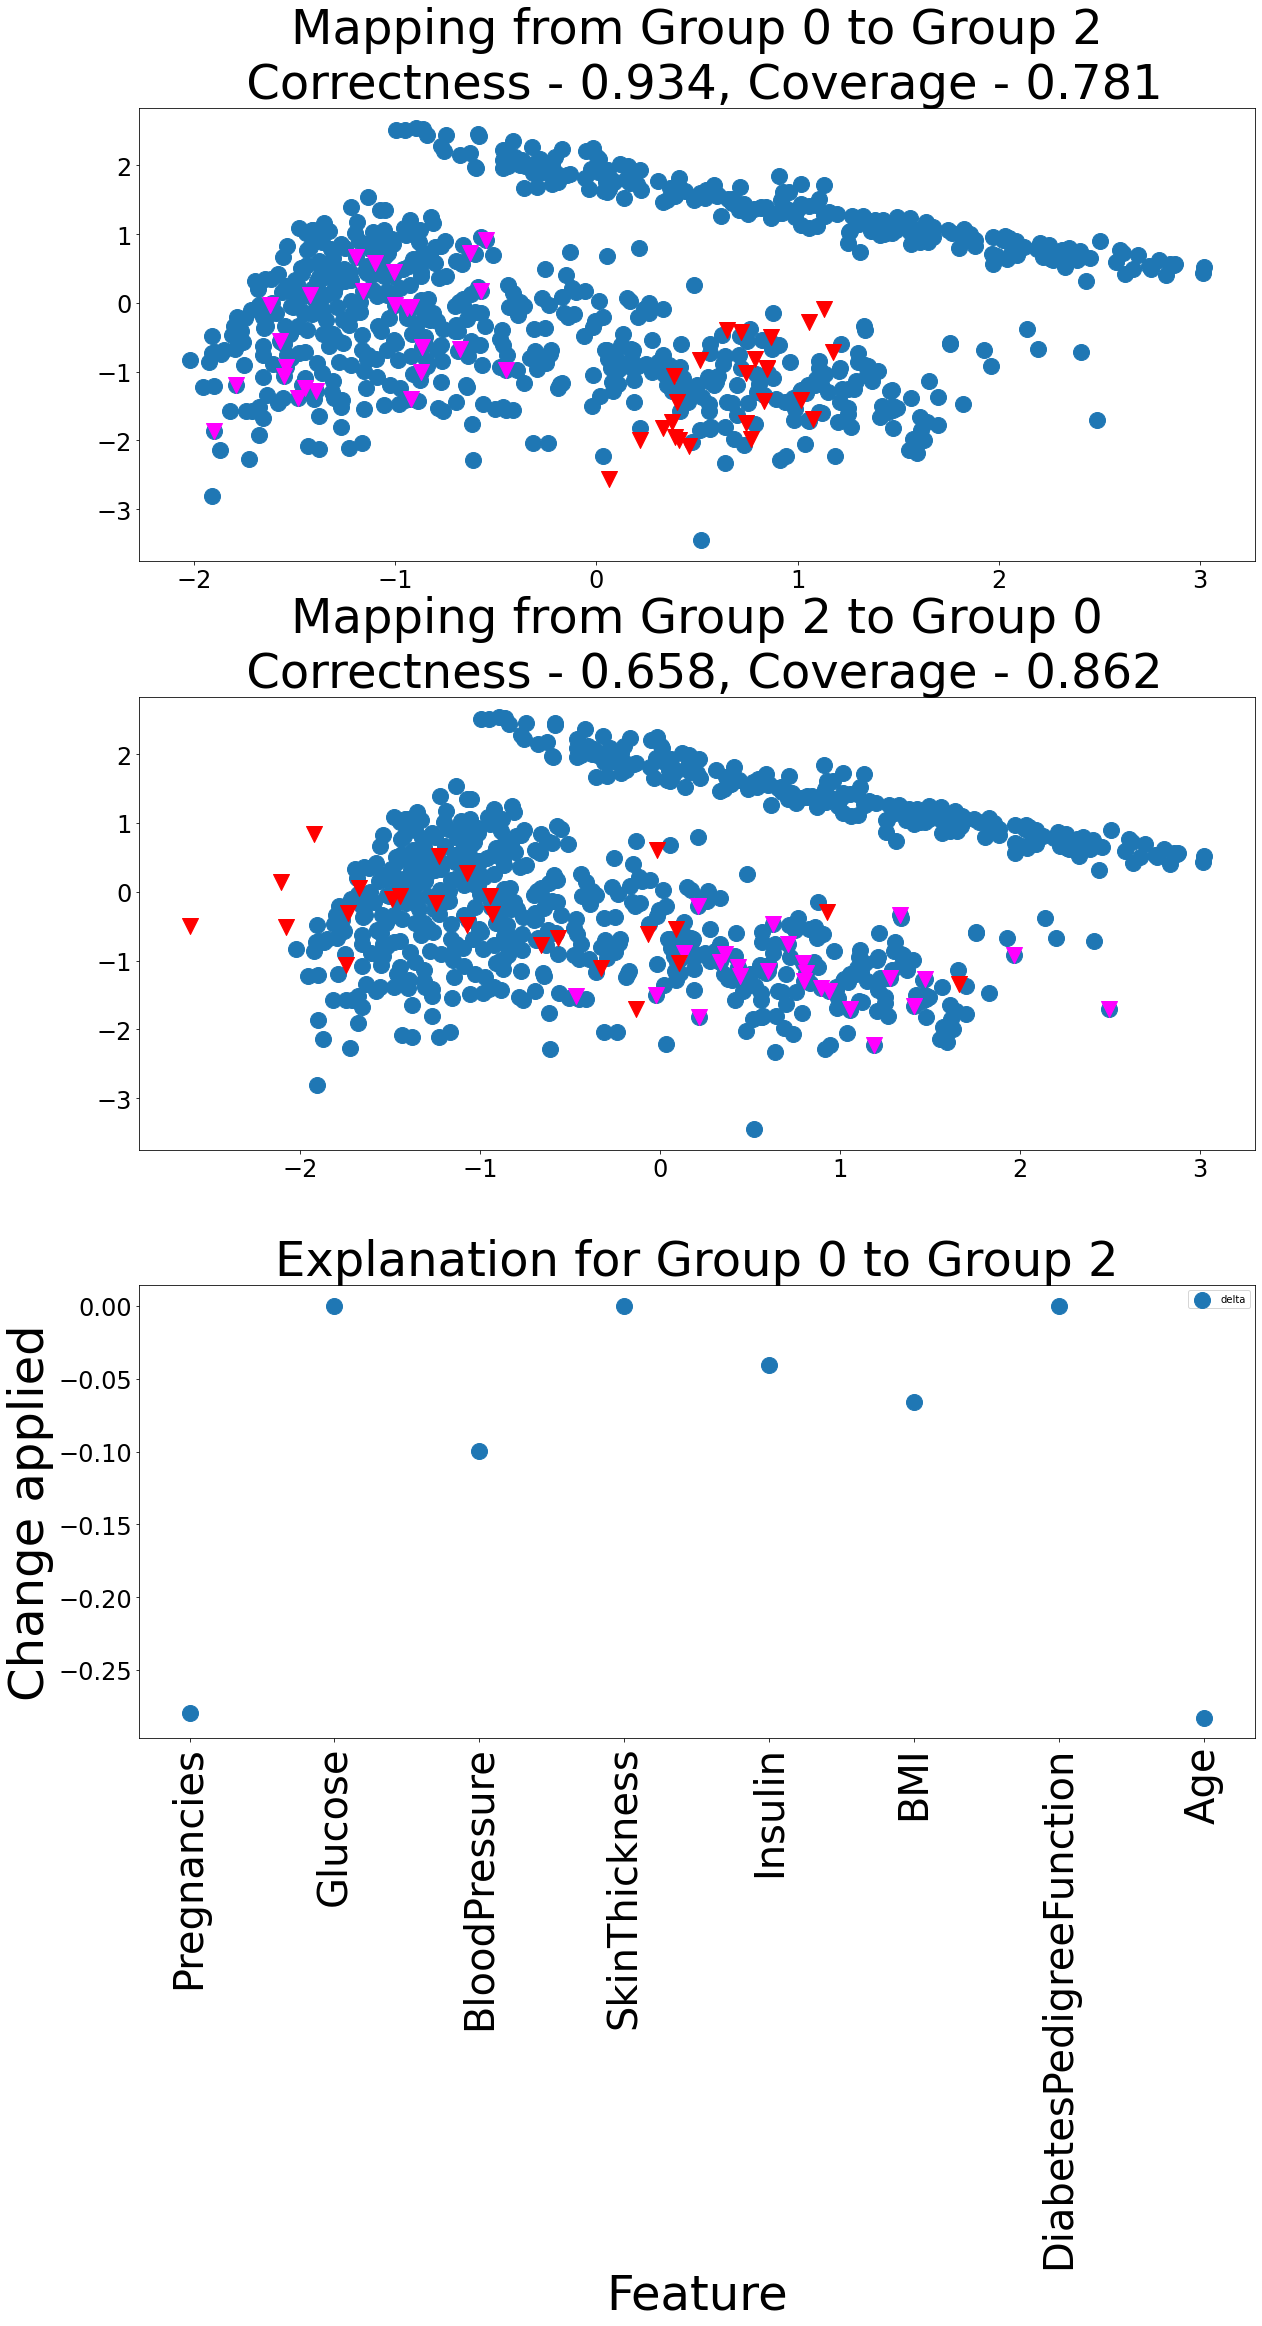

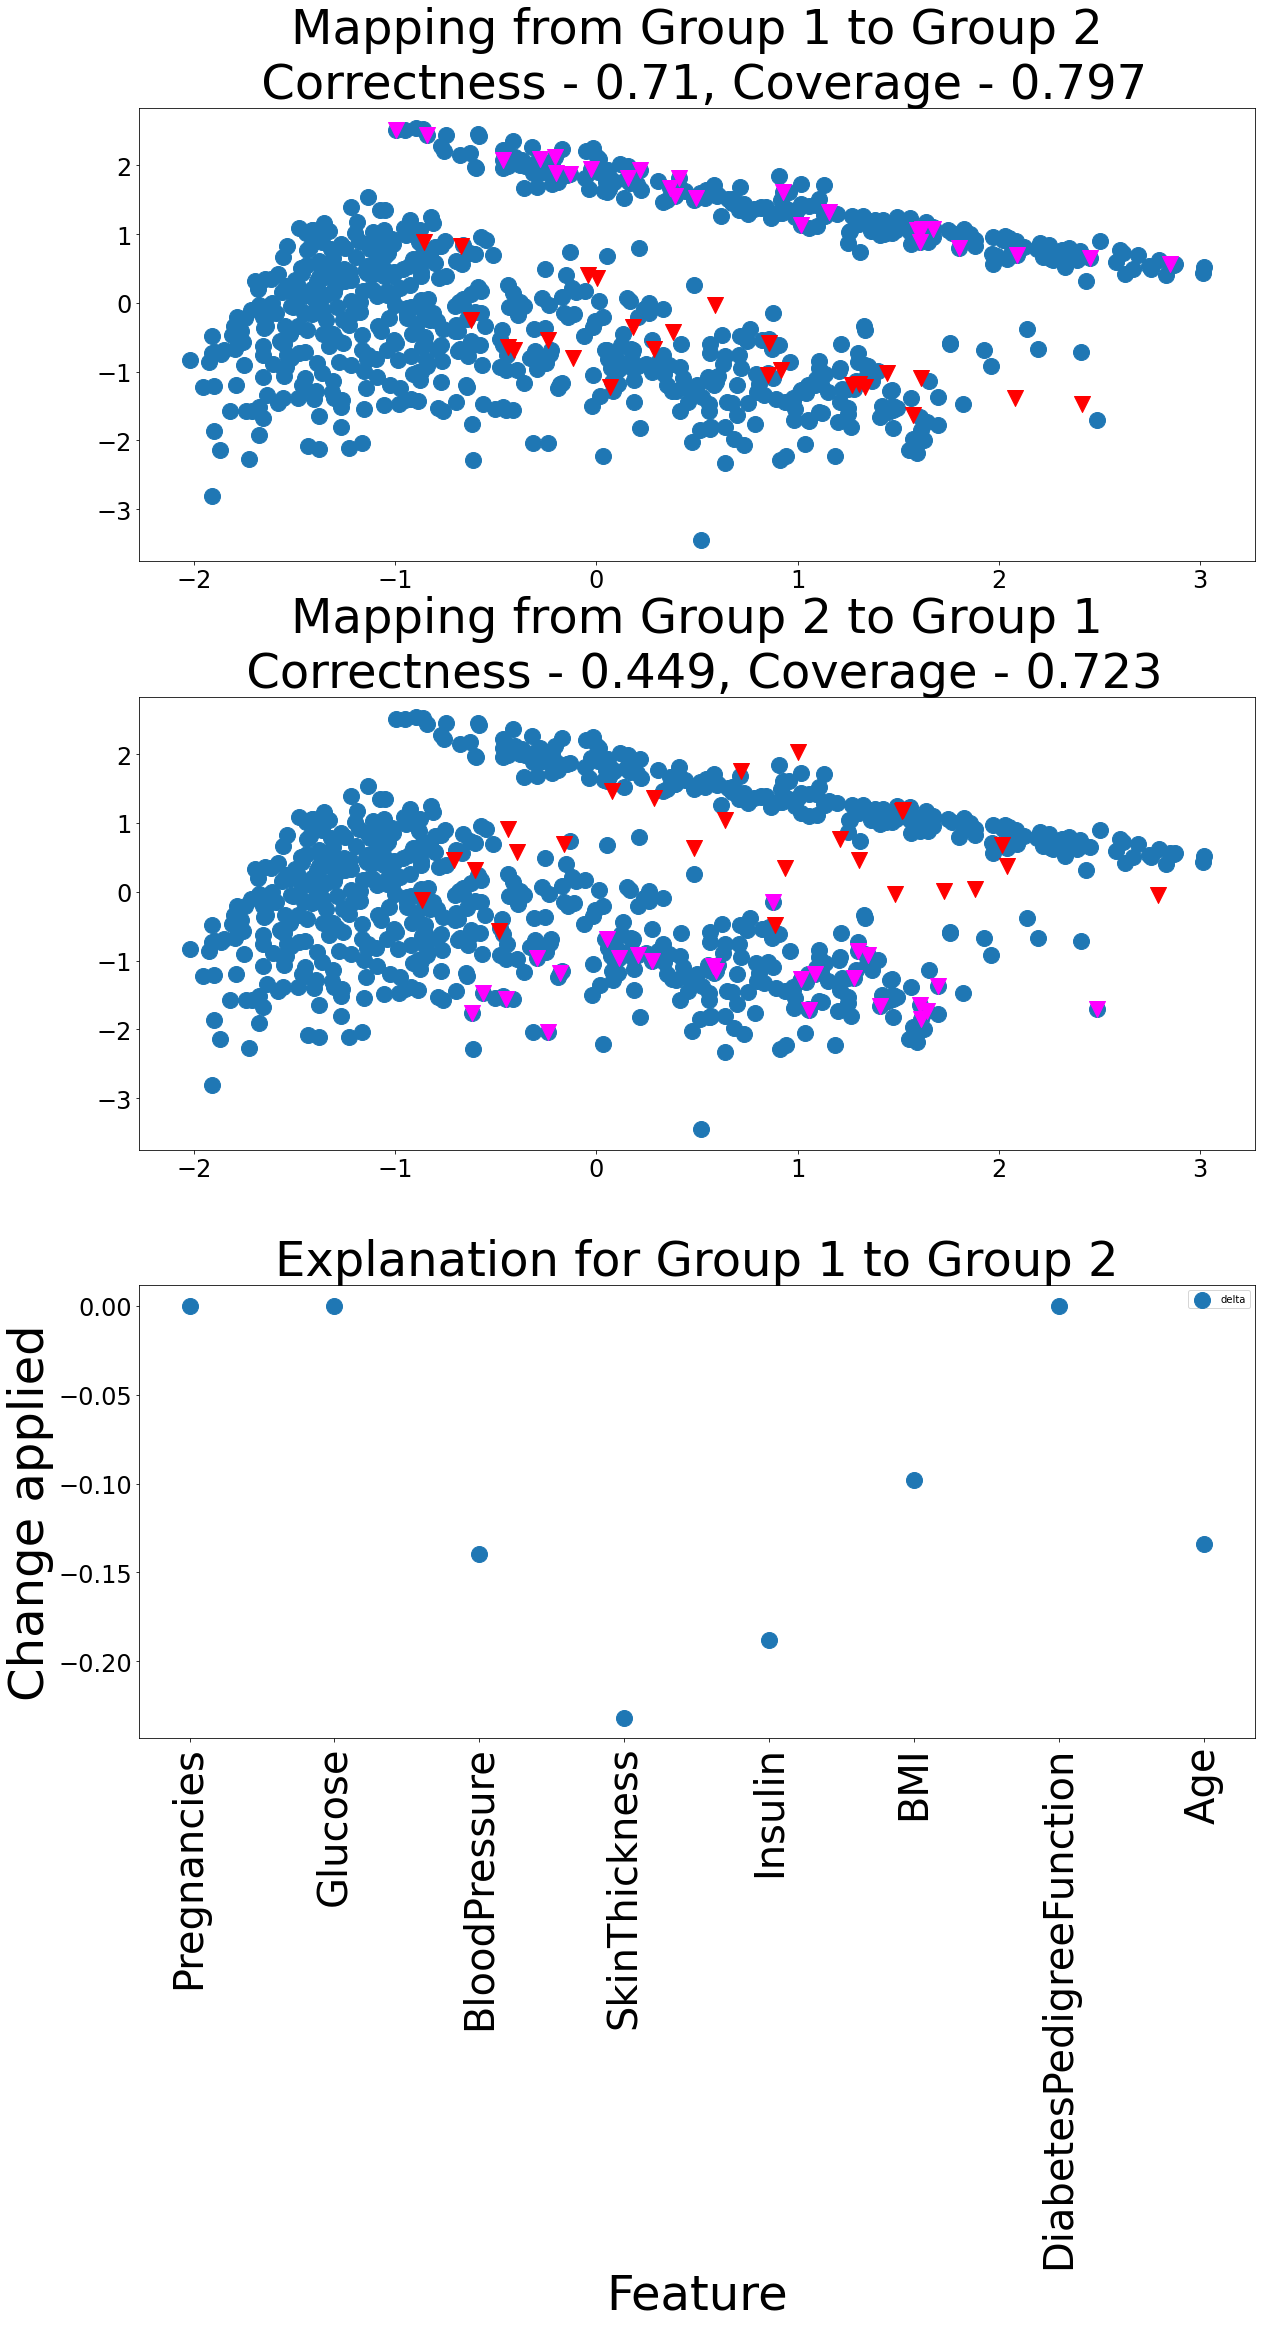

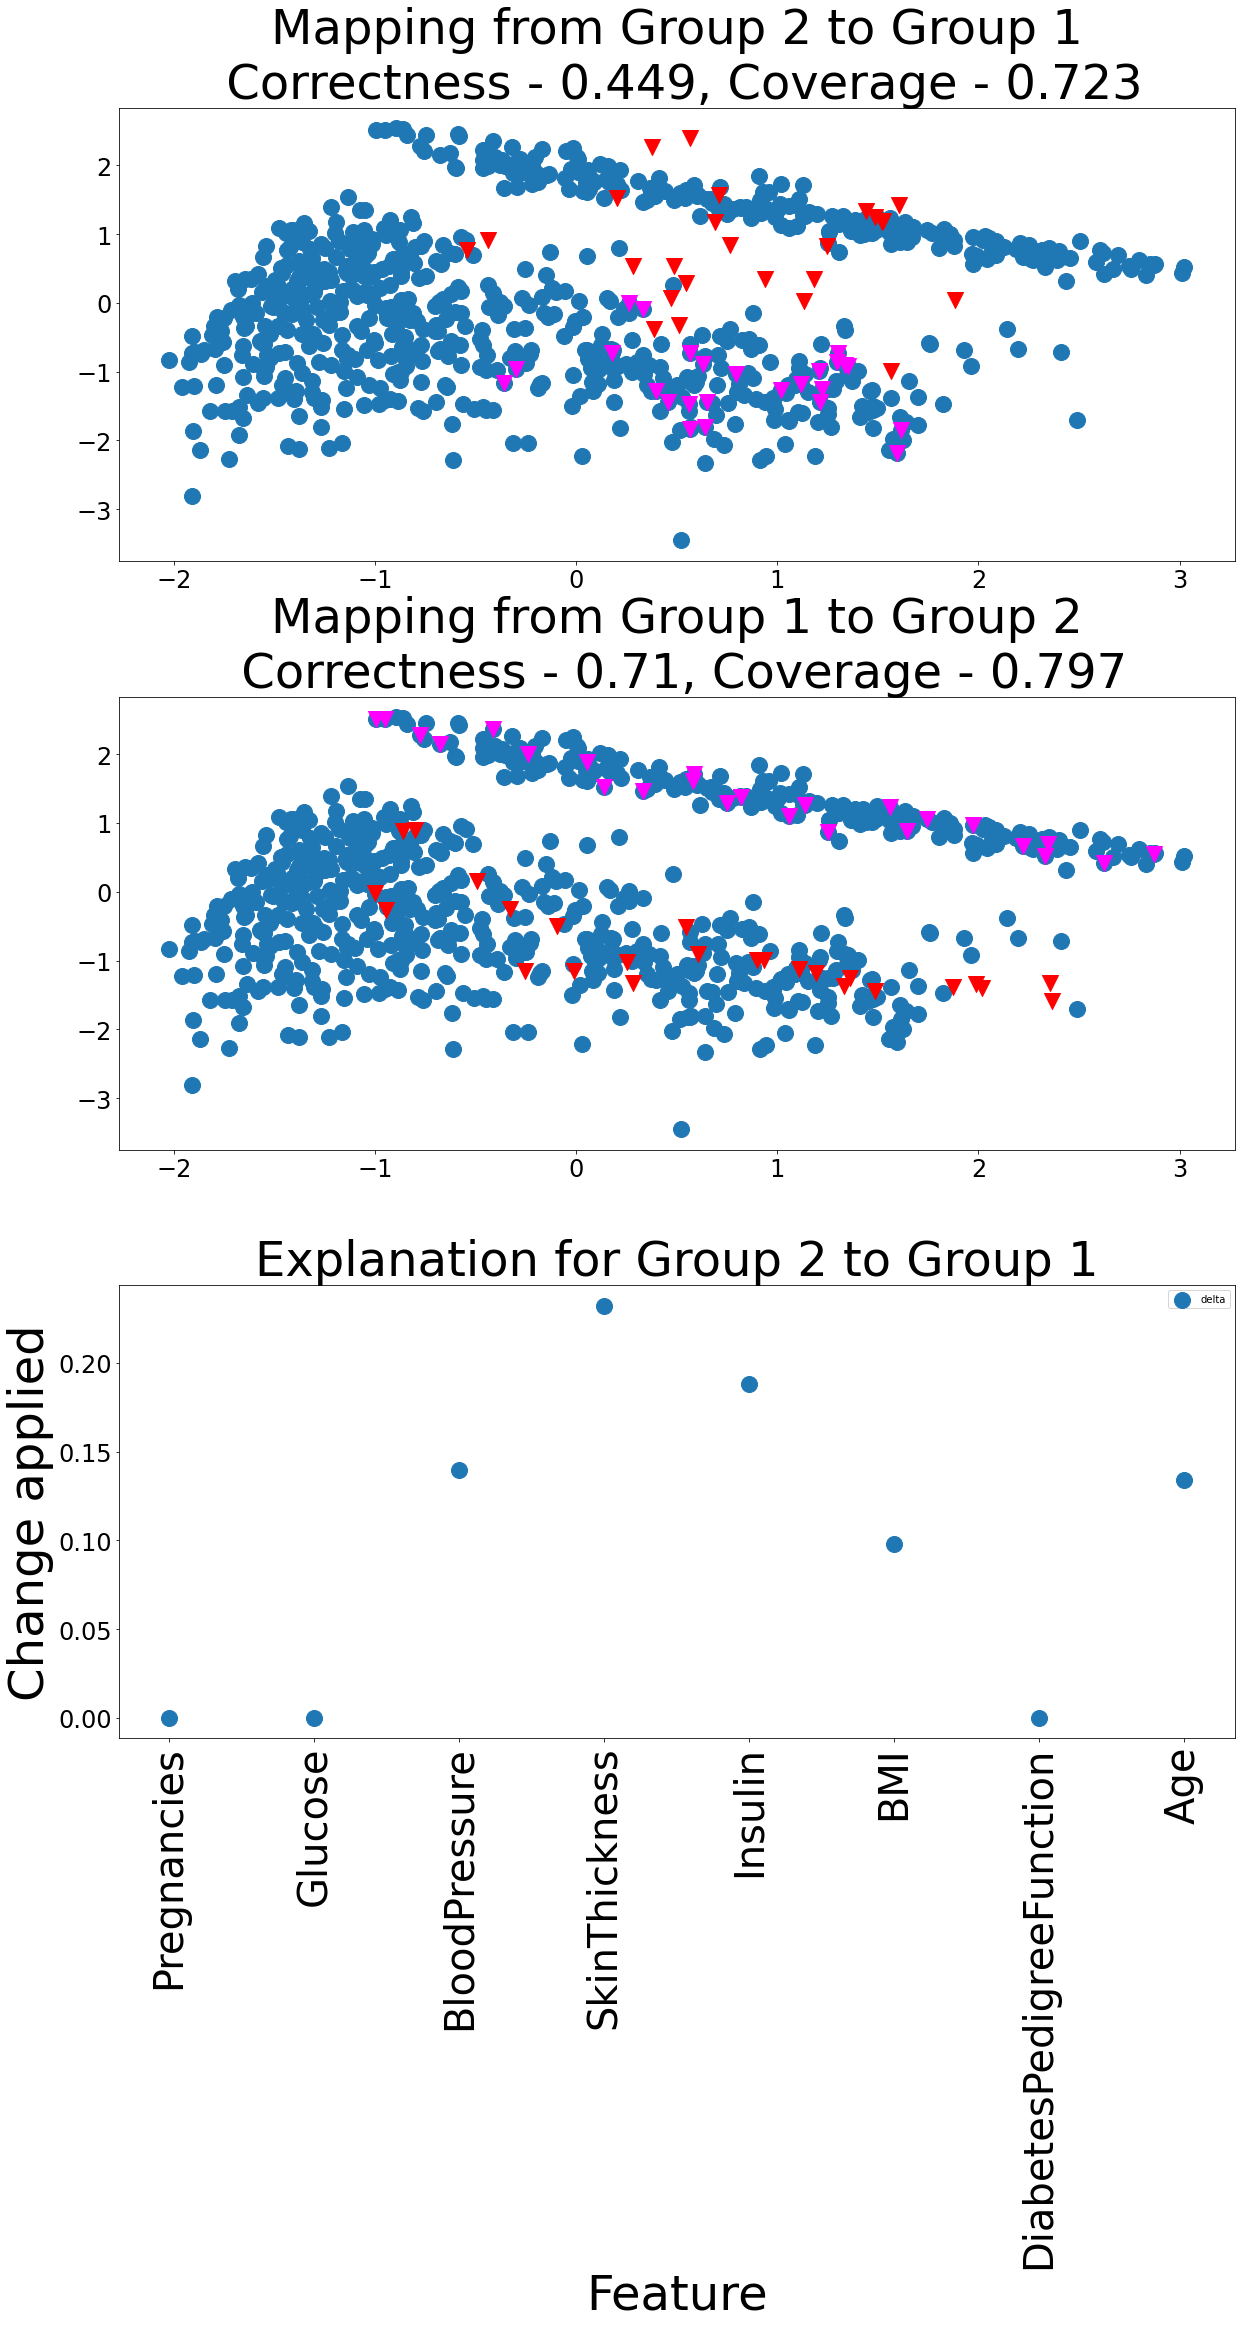

In [19]:
# Evaluate the explanations
from eldr.plotter.myplot import *
k = 5
import torch
feature_names = list(pd.read_csv(f'{base_path}/Data/diabetes/diabetes.csv').columns)[:-1]
exp_path = f'{base_path}experiments/Diabetes_scaling/'

deltas_ = np.load("deltas/deltas" + str(k) + ".npy")
np.set_printoptions(suppress=True)

Explainer = Explain(model, means, centers)

a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas_), epsilon, k = k)

plot_metrics(a, b, name = "diabetes-scaling-metrics.png")

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 1, k = k, num_points = 25, name = "diabetes-0to1.png", feature_names = feature_names)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 0, k = k,  num_points = 25, name = "diabetes-1to0.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 2, k = k, num_points = 25, name = "diabetes-0to2.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 2, k = k,  num_points = 25, name = "diabetes-1to2.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 2, 1, k = k,  num_points = 25, name = "diabetes-2to1.png", feature_names = feature_names)

In [22]:
out = np.loadtxt("out.csv", delimiter = ",")
K = [1, 3, 5, 7, 9, 11, 13] 
print(out)

[[ 1.          0.72510851  0.78017921  0.71019555  0.78557699]
 [ 3.          0.7685341   0.81892419  0.71804186  0.79552372]
 [ 5.          0.76398564  0.84404988  0.72164187  0.81232452]
 [ 7.          0.76877497  0.84559155  0.72396937  0.81273491]
 [ 9.          0.76543553  0.84538636  0.72998199  0.81027308]
 [11.          0.80262482  0.8438378   0.72998199  0.81027308]
 [13.          0.79154657  0.84269176  0.72998199  0.81027308]]


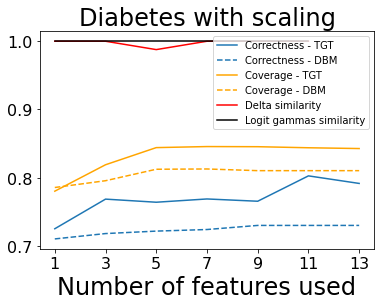

In [24]:
from eldr.misc import load
import matplotlib
matplotlib.rc("xtick", labelsize = 16)
matplotlib.rc("ytick", labelsize = 16)
matplotlib.rc("axes", titlesize = 24)
matplotlib.rc("axes", labelsize = 24)
out_path = f'{base_path}experiments/Diabetes_scaling/out.csv'
results_path = f'{exp_path}/deltas/'
out = np.loadtxt(out_path, delimiter=",")
S_deltas = np.zeros(len(K) - 1)
S_gammas = np.zeros(len(K) - 1)
S_range = []
for c in range(len(K) - 1):
    k_more = K[c]
    k_less = K[c + 1]
    
    d_more = np.load(f"{results_path}deltas" + str(k_more) + ".npy")
    d_less = np.load(f"{results_path}deltas" + str(k_less) + ".npy")
    g_more = np.load(f"{results_path}logit_gammas" + str(k_more) + ".npy")
    g_less = np.load(f"{results_path}logit_gammas" + str(k_less) + ".npy")
    
    res_deltas = np.ones((num_clusters, num_clusters))
    res_gammas = np.ones((num_clusters, num_clusters))
    
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                e_d_more = load(d_more, k_more, i, j).numpy()
                e_d_less = load(d_less, k_less, i, j).numpy()
                e_g_more = load(g_more, k_more, i, j).numpy()
                e_g_less = load(g_less, k_less, i, j).numpy()
                
                res_deltas[i,j] = Explainer.similarity(e_d_more, e_d_less)
                res_gammas[i,j] = Explainer.similarity(e_g_more, e_g_less)
    S_deltas[c] = np.mean(res_deltas)
    S_gammas[c] = np.mean(res_gammas)
    S_range.append(k_more)

plt.plot(out[:, 0], out[:, 1], c = "C0", label = "Correctness - TGT")
plt.plot(out[:, 0], out[:, 3], ls = "--", c= "C0", label = "Correctness - DBM")
plt.plot(out[:, 0], out[:, 2], c = "orange", label = "Coverage - TGT")
plt.plot(out[:, 0], out[:, 4], ls = "--", color = "orange", label = "Coverage - DBM")
plt.plot(S_range, S_deltas, c = 'red', label='Delta similarity')
plt.plot(S_range, S_gammas, c = 'black', label='Logit gammas similarity')

plt.xlabel('Number of features used')
plt.title('Diabetes with scaling')
plt.xticks(np.arange(1, 15, step=2))
plt.legend()

plt.savefig("diabetesscaling-tradeoff.png", bbox_inches='tight')
plt.show()
plt.close()